In [1]:
%load_ext autoreload
%autoreload 2

device = 'cuda'

In [2]:
import torch

In [3]:
from pianogen.dataset.pianorolldataset import PianoRollDataset
from pianogen.dataset.tokenized import TokenizedPianoRollDataset
from pianogen.tokenizer import PianoRollTokenizer
from torch.utils.data import DataLoader

pr_ds = PianoRollDataset(r'W:\music\music-data-analysis\data', max_duration=32*150, segment_len=32, hop_len=32) # 1 bar
tokenizer = PianoRollTokenizer(n_pitch=88, n_velocity=32, token_seq_len=120+1)
ds = TokenizedPianoRollDataset(pr_ds, tokenizer)
dl = DataLoader(ds,batch_size=32, shuffle=True, num_workers=8)

Loaded 253780 samples from 2570 songs


ok so we need a vae, where

the encoder is sequence in, embedding out

the latent is the embedding

the decoder is the embedding in, sequence out

In [4]:
import torch.nn as nn

from pianogen.model.model import BinaryPositionalEncoding, SinusoidalPositionalEncoding

class PositionalEncoding(nn.Module):
    def __init__(self, binary_pe_dim, sinusoidal_pe_dim, max_len):
        super().__init__()
        self.binary_pos_encoding = BinaryPositionalEncoding(binary_pe_dim, max_len)
        self.sinusoidal_pos_encoding = SinusoidalPositionalEncoding(sinusoidal_pe_dim, max_len)

    def forward(self, x):
        return torch.cat([self.binary_pos_encoding(x), self.sinusoidal_pos_encoding(x)*0], dim=-1)

class Encoder(nn.Module):
    '''
    eats a sequence of tokens, and outputs an embedding at the emb token
    no masking
    '''
    def __init__(self, input_dim, output_dim, feature_dim, max_len, n_heads=8, n_layers=6, ff_dim=1024):
        super().__init__()
        self.emb_token_idx = input_dim # the last token is the embedding token
        self.pe = PositionalEncoding(5, feature_dim//2-5, max_len)
        self.emb = nn.Embedding(input_dim+1, feature_dim)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(feature_dim, n_heads, ff_dim, batch_first=True), n_layers)
        self.output_layer = nn.Linear(feature_dim, output_dim*2)

    def forward(self, x: torch.Tensor, pos: torch.Tensor):
        #x: B, L
        # add emb token
        x = torch.cat([x, torch.zeros(x.shape[0], 1, device=x.device, dtype=torch.long)+self.emb_token_idx], dim=1)
        # x: B, L+1

        # embed
        x = self.emb(x)

        # add positional encoding
        pe = self.pe(pos)
        pe = torch.cat([pe, torch.zeros_like(pe[:,0:1,:])], dim=1) # B, L+1, D
        x[:,:,:pe.shape[2]] += pe

        x = self.transformer(x)
        x = x[:,-1] # get the embedding
        x = self.output_layer(x)
        mean, logvar = x.chunk(2, dim=1)
        logvar = logvar - 6 # make var start small for faster learning
        return mean, logvar

class Decoder(nn.Module):
    '''
    eats an embedding, and outputs a sequence of tokens autoregressively
    '''
    def __init__(self, input_dim:int, output_dim:int, feature_dim:int, max_len:int, n_heads:int=8, n_layers:int=6, ff_dim:int=1024):
        super().__init__()
        self.emb = nn.Embedding(input_dim, feature_dim)
        self.pe = PositionalEncoding(5, feature_dim//2-5, max_len)
        self.input_layer = nn.Linear(input_dim*2, feature_dim)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(feature_dim, n_heads, ff_dim, batch_first=True), n_layers)
        self.output_layer = nn.Linear(feature_dim, output_dim)

    def forward(self, latent: torch.Tensor, seq: torch.Tensor, pos: torch.Tensor):
        #latent: B, D_latent
        #seq: B, L
        x = self.emb(seq)

        # add positional encoding
        pe = self.pe(pos)
        pe = torch.cat([
            pe[:, :-1], # pe of the input tokens
            pe[:, 1:]   # pe of the target tokens
        ], dim=2) # B, L, D
        x = x + pe

        # incorporate latent
        latent = latent.unsqueeze(1) # B, 1, D
        latent = latent.expand(-1, x.shape[1], -1) # B, L, D
        x = torch.cat([x, latent], dim=2)
        x = self.input_layer(x)

        # have to be causal
        x = self.transformer.forward(x, mask=nn.Transformer.generate_square_subsequent_mask(x.shape[1]).to(x.device), is_causal=True)
        x = self.output_layer(x)
        return x


class VAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, seq: torch.Tensor, pos: torch.Tensor, return_latent: bool=False):
        latent_mean, latent_logvar = self.encoder(seq[:,1:], pos[:,1:])
        latent = self.reparameterize(latent_mean, latent_logvar)
        #latent = latent_mean
        if return_latent:
            latent_loss = self.latent_loss(latent_mean, latent_logvar)
            return self.decoder(latent, seq[:,:-1], pos), latent, latent_mean, latent_logvar, latent_loss
        else:
            return self.decoder(latent, seq[:,:-1], pos)
        

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor):
        # mean: B, L
        # logvar: B, L
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def latent_loss(self, mean: torch.Tensor, logvar: torch.Tensor):
        return torch.mean(-0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1))

In [5]:

from pathlib import Path
import random
from typing import Literal
from tqdm import tqdm
from music_data_analysis.data import Pianoroll
from pianogen.gpu_temp_control import GPUTempControl

gpu_control = GPUTempControl(64,3)

tokenizer: PianoRollTokenizer
vae: VAE
def inference(latent:torch.Tensor, file_path:str|Path, length:int=120, prompt:Pianoroll|None=None, batch_size:int|None=None,method:Literal['nucleus','top_k']='nucleus', p=0.9, top_k:int=15):
    vae.eval()
    if prompt is None:
        tokens = [{'type':'start'}]
    else:
        tokens = ds.tokenizer.tokenize(prompt, pad=False)
        print('prompt:', tokens[:10])
        print('prompt end:', tokens[-10:])

    indices = tokenizer.vocab.tokens_to_indices(tokens)
    pos = tokenizer.get_frame_indices(tokens, infer_next_frame=True)
    indices = indices.unsqueeze(0).to(device)
    pos = pos.unsqueeze(0).to(device)

    last_token = tokens[-1]

    for _ in tqdm(range(length-len(tokens))):
        gpu_control.cooldown()

        logits = vae.decoder(latent, indices, pos).squeeze(0)[-1].detach().cpu()
        new_token = tokenizer.sample_from_logits(logits, last_token, method=method, p=p, top_k=top_k)
        tokens.append(new_token)
        last_token = new_token

        # update indices and pos

        new_token_idx = tokenizer.vocab.get_idx(new_token)
        indices = torch.cat([indices, torch.tensor([[new_token_idx]]).to(device)], dim=-1)
        if new_token['type'] == 'next_frame':
            new_pos = pos[0,-1] + 1
        else:
            new_pos = pos[0,-1]
        pos = torch.cat([pos, torch.tensor([[new_pos]]).to(device)], dim=-1)

        if new_token['type'] == 'end':
            break

    pr = tokenizer.detokenize(tokens).slice(0,32)
    pr.to_midi(file_path)
    print(len(tokens),' tokens :', tokens[:10])
    return pr

def gaussian_pdf(mean, var, x):
    result = torch.exp(-0.5 * (x-mean).pow(2) / var) / torch.sqrt(2 * torch.pi * var)
    return result.prod(dim=-1)

def log_gaussian_pdf(mean, var, x):
    result = torch.exp(-0.5 * (x-mean).pow(2) / var) / torch.sqrt(2 * torch.pi * var)
    return result.log().sum(dim=-1)

def get_confidence(mean, var):
    B = mean.shape[0]
    s = 0
    n=64
    for _ in range(n):
        i = random.randint(0,B-1)
        j = random.randint(0,B-1)
        if i==j:
            j = (j+1)%B
        log_p1 = log_gaussian_pdf(mean[i], var[i], mean[i])
        log_p2 = log_gaussian_pdf(mean[j], var[j], mean[i])
        log_p2 -= log_p1
        log_p1 -= log_p1
        p1 = log_p1.exp()
        p2 = log_p2.exp()
        s += p1/(p1+p2)
    return s/n

In [6]:
from pathlib import Path
from torch.utils.tensorboard.writer import SummaryWriter

exp_name = 'vae/1002_latent_loss_1e-4_cor1'
device = 'cuda'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')


encoder = Encoder(input_dim=len(tokenizer.vocab), output_dim=256, feature_dim=256, max_len=120, n_heads=8, n_layers=3, ff_dim=1024)
decoder = Decoder(input_dim=256, output_dim=len(tokenizer.vocab), feature_dim=256, max_len=120, n_heads=8, n_layers=6, ff_dim=1024)
vae = VAE(encoder, decoder)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = torch.optim.Adam(vae.parameters(),lr=2e-4)

writer = SummaryWriter(tensorboard_dir)

print('number of parameters:', sum(p.numel() for p in vae.parameters())/1e6, 'M')

number of parameters: 7.500156 M


In [7]:
from_epoch = 0
epoch = from_epoch
# load from checkpoint
if from_epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{from_epoch}.pt')
    vae.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
vae = vae.to(device)

In [8]:
epoch

0

In [45]:
# train
import random
from pianogen import gpu_temp_control
from tqdm import tqdm
temp_control = gpu_temp_control.GPUTempControl(64,3)

vae.to(device)
crit.to(device)

vae.train()

for epoch in range(from_epoch+1,12):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        B = batch['indices'].shape[0]
        batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
        opt.zero_grad()
        reconst, latent, latent_mean, latent_logvar, latent_loss = vae(batch['indices'], batch['pos'], return_latent = True)
        reconst_loss = crit((reconst+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss = reconst_loss + latent_loss*1e-4

        latent.retain_grad()

        loss.backward()
        opt.step()
        temp_control.cooldown()
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")

        writer.add_scalar('loss', loss.item(), epoch*len(dl)+i)
        writer.add_scalar('latent_loss', latent_loss.item(), epoch*len(dl)+i)
        writer.add_scalar('reconst_loss', reconst_loss.item(), epoch*len(dl)+i)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), epoch*len(dl)+i)
        if i % 100 == 0:
            accuracy = ((reconst.argmax(dim=-1) == batch['indices'][:,1:])[batch['indices'][:,1:]>0]).float().mean().item()
            writer.add_scalar('accuracy', accuracy, epoch*len(dl)+i)

            
            writer.add_scalar('latent_grad', latent.grad.norm(1).mean().item(), epoch*len(dl)+i)
            writer.add_scalar('confidence', get_confidence(latent_mean, latent_logvar.exp()), epoch*len(dl)+i)
            
            
        if i % 500 == 0:

            latent_samples = []
            for _ in range(10):
                latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
            latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3
            writer.add_embedding(tag='latent_samples',mat=latent_samples, metadata=[i for _ in range(10) for i in range(B) ],global_step=epoch*len(dl)+i)
            
            
            pr = inference(torch.randn(1, 256).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
            writer.add_image('random', pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127, epoch*len(dl)+i,dataformats='HW')
            
            latent_mean, _ = vae.encoder.forward(batch['indices'][0:1,:-1], batch['pos'][0:1, :-1]) # use one sample from the batch as gt
            pr = inference(latent_mean, output_dir/f'{epoch}_{i}_reconstruct.mid', length=120)
            gt_pr = tokenizer.detokenize(tokenizer.idx_to_token_seq(batch['indices'][0].cpu().numpy()))
            
            writer.add_image('reconstruct', torch.cat([
                pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127,
                gt_pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127
            ], dim=1), epoch*len(dl)+i,dataformats='HW')

            
            
            gt_pr.to_midi(output_dir/f'{epoch}_{i}_gt.mid')


    if epoch % 2 == 0:
        torch.save({'model':vae.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')
    



  0%|          | 0/7931 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:00<00:00, 143.71it/s]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


  0%|          | 4/7931 [00:20<8:45:08,  3.97s/it] 

120  tokens : [{'type': 'start'}, {'value': 31, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}]


  6%|▋         | 499/7931 [01:16<17:01,  7.28it/s] 

100%|██████████| 119/119 [00:01<00:00, 116.54it/s]


120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}]


  6%|▋         | 503/7931 [01:18<37:22,  3.31it/s]

120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 25, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 37, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 40, 'type': 'pitch'}]


 13%|█▎        | 999/7931 [02:19<15:02,  7.68it/s]

100%|██████████| 119/119 [00:00<00:00, 122.10it/s]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


 13%|█▎        | 1003/7931 [02:22<38:40,  2.99it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 19%|█▉        | 1500/7931 [03:23<13:44,  7.80it/s]

100%|██████████| 119/119 [00:01<00:00, 114.90it/s]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 19%|█▉        | 1502/7931 [03:25<40:51,  2.62it/s]

120  tokens : [{'type': 'start'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


 25%|██▌       | 1998/7931 [04:25<14:21,  6.89it/s]

100%|██████████| 119/119 [00:01<00:00, 114.24it/s]


120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 25, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 25%|██▌       | 2003/7931 [04:27<28:34,  3.46it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 31%|███▏      | 2498/7931 [05:25<12:26,  7.27it/s]

100%|██████████| 119/119 [00:00<00:00, 119.76it/s]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}]


 32%|███▏      | 2503/7931 [05:28<25:12,  3.59it/s]

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


 38%|███▊      | 2999/7931 [06:26<11:10,  7.35it/s]

100%|██████████| 119/119 [00:00<00:00, 125.18it/s]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


 38%|███▊      | 3003/7931 [06:29<28:15,  2.91it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 44%|████▍     | 3498/7931 [07:27<10:38,  6.95it/s]

100%|██████████| 119/119 [00:00<00:00, 123.94it/s]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:30<20:31,  3.60it/s]

120  tokens : [{'type': 'start'}, {'value': 0, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 50%|█████     | 4000/7931 [08:29<08:48,  7.44it/s]

100%|██████████| 119/119 [00:01<00:00, 115.24it/s]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4005/7931 [08:31<16:42,  3.91it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}]


 57%|█████▋    | 4499/7931 [09:30<07:55,  7.21it/s]

100%|██████████| 119/119 [00:00<00:00, 129.82it/s]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}]


 57%|█████▋    | 4503/7931 [09:32<16:33,  3.45it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 114.41it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 9, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


 63%|██████▎   | 5003/7931 [10:34<14:42,  3.32it/s]

120  tokens : [{'type': 'start'}, {'value': 5, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 17, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 134.37it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}]


 69%|██████▉   | 5503/7931 [11:33<10:13,  3.96it/s]

120  tokens : [{'type': 'start'}, {'value': 51, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.70it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 26, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


 76%|███████▌  | 6003/7931 [12:35<09:11,  3.49it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.12it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}]


 82%|████████▏ | 6503/7931 [13:36<07:52,  3.02it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 124.00it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 33, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 7003/7931 [14:39<05:57,  2.60it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 111.25it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}]


 95%|█████████▍| 7503/7931 [15:40<02:09,  3.30it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 135.67it/s]


120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 37, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 52, 'type': 'pitch'}]


  0%|          | 5/7931 [00:20<6:45:27,  3.07s/it] 

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.44it/s] 


120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  6%|▋         | 502/7931 [01:18<42:50,  2.89it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 123.36it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:19<37:22,  3.09it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.10it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}]


 19%|█▉        | 1503/7931 [03:20<29:43,  3.60it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.79it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 25%|██▌       | 2003/7931 [04:21<30:49,  3.21it/s]

120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.37it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 72, 'type': 'pitch'}]


 32%|███▏      | 2502/7931 [05:23<34:43,  2.61it/s]

120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 125.18it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 30, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 69, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 38%|███▊      | 3003/7931 [06:24<24:54,  3.30it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.19it/s]]


120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


 44%|████▍     | 3504/7931 [07:25<22:06,  3.34it/s]

120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.63it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}]


 50%|█████     | 4003/7931 [08:26<22:20,  2.93it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.29it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


 57%|█████▋    | 4502/7931 [09:27<27:12,  2.10it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.85it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 63%|██████▎   | 5004/7931 [10:28<16:00,  3.05it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 112.46it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5503/7931 [11:29<11:43,  3.45it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 120.67it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}]


 76%|███████▌  | 6003/7931 [12:30<10:32,  3.05it/s]

120  tokens : [{'type': 'start'}, {'value': 43, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.24it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}]


 82%|████████▏ | 6503/7931 [13:32<07:11,  3.31it/s]

120  tokens : [{'type': 'start'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 41, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 112.51it/s]]


120  tokens : [{'type': 'start'}, {'value': 18, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 7004/7931 [14:33<04:50,  3.19it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.08it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 27, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 53, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}]


 95%|█████████▍| 7503/7931 [15:34<02:26,  2.92it/s]

120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 68, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 142.91it/s]


120  tokens : [{'type': 'start'}, {'value': 3, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}]


  0%|          | 3/7931 [00:22<12:47:31,  5.81s/it]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 122.46it/s] 


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 50, 'type': 'pitch'}]


  6%|▋         | 504/7931 [01:21<37:08,  3.33it/s]

120  tokens : [{'type': 'start'}, {'value': 16, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 28, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.36it/s]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:21<35:24,  3.26it/s]

120  tokens : [{'type': 'start'}, {'value': 62, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 74, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 132.27it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}]


 19%|█▉        | 1503/7931 [03:22<32:39,  3.28it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 120.24it/s]]


120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 10, 'type': 'pitch'}]


 25%|██▌       | 2003/7931 [04:23<28:38,  3.45it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 125.23it/s]]


120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


 32%|███▏      | 2505/7931 [05:24<24:31,  3.69it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 108.22it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}]


 38%|███▊      | 3003/7931 [06:24<26:21,  3.12it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.30it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:25<20:51,  3.54it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 7, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 104.00it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 52, 'type': 'pitch'}, {'value': 27, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 50%|█████     | 4003/7931 [08:27<21:03,  3.11it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 127.18it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 57%|█████▋    | 4503/7931 [09:27<18:02,  3.17it/s]

120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 113.85it/s]]


120  tokens : [{'type': 'start'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


 63%|██████▎   | 5003/7931 [10:28<16:16,  3.00it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.97it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5503/7931 [11:29<10:53,  3.72it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 115.28it/s]]


120  tokens : [{'type': 'start'}, {'value': 5, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 17, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}]


 76%|███████▌  | 6003/7931 [12:30<10:38,  3.02it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 118.79it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


 82%|████████▏ | 6504/7931 [13:31<07:20,  3.24it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 115.73it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}]


 88%|████████▊ | 7003/7931 [14:31<05:11,  2.98it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 119.21it/s]]


120  tokens : [{'type': 'start'}, {'value': 53, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 95%|█████████▍| 7503/7931 [15:32<02:11,  3.27it/s]

120  tokens : [{'type': 'start'}, {'value': 49, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 69, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 130.83it/s]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  0%|          | 3/7931 [00:21<12:29:24,  5.67s/it]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.52it/s] 


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


  6%|▋         | 503/7931 [01:20<36:09,  3.42it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.99it/s]


120  tokens : [{'type': 'start'}, {'value': 26, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 40, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


 13%|█▎        | 1003/7931 [02:22<35:45,  3.23it/s]

120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 26, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 113.32it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


 19%|█▉        | 1504/7931 [03:23<33:42,  3.18it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 122.41it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 25%|██▌       | 2003/7931 [04:23<29:47,  3.32it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 113.21it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 32%|███▏      | 2504/7931 [05:26<27:53,  3.24it/s]

120  tokens : [{'type': 'start'}, {'value': 80, 'type': 'pitch'}, {'value': 28, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.74it/s]]


120  tokens : [{'type': 'start'}, {'value': 42, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 21, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}]


 38%|███▊      | 3005/7931 [06:27<22:05,  3.72it/s]

120  tokens : [{'type': 'start'}, {'value': 38, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 45, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 127.46it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 26, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:27<21:21,  3.46it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 121.04it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4002/7931 [08:28<25:49,  2.54it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 128.42it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4503/7931 [09:29<17:15,  3.31it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 119.40it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 61, 'type': 'pitch'}]


 63%|██████▎   | 5004/7931 [10:30<13:46,  3.54it/s]

120  tokens : [{'type': 'start'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 49, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.47it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 44, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5504/7931 [11:31<11:08,  3.63it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 14, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.75it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 7, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 76%|███████▌  | 6003/7931 [12:32<10:17,  3.12it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 110.32it/s]]


120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 73, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:33<07:49,  3.04it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 62, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 119.82it/s]]


120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 25, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 7002/7931 [14:35<05:26,  2.84it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.01it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}]


 95%|█████████▍| 7503/7931 [15:35<02:08,  3.33it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 145.35it/s]


120  tokens : [{'type': 'start'}, {'value': 3, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


  0%|          | 3/7931 [00:21<12:26:22,  5.65s/it]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 123.93it/s] 


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 71, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


  6%|▋         | 503/7931 [01:22<43:09,  2.87it/s]  

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 122.59it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:22<37:40,  3.07it/s]

120  tokens : [{'type': 'start'}, {'value': 41, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 113.47it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 58, 'type': 'pitch'}]


 19%|█▉        | 1503/7931 [03:23<31:15,  3.43it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 127.73it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 49, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


 25%|██▌       | 2004/7931 [04:23<29:06,  3.39it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 15, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 130.81it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 64, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 71, 'type': 'pitch'}]


 32%|███▏      | 2503/7931 [05:23<26:52,  3.37it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.16it/s]]


120  tokens : [{'type': 'start'}, {'value': 49, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 61, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 38%|███▊      | 3003/7931 [06:24<27:43,  2.96it/s]

120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 49, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 52, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 30, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.67it/s]]


120  tokens : [{'type': 'start'}, {'value': 58, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:25<23:25,  3.15it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 114.78it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 42, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}]


 50%|█████     | 4004/7931 [08:27<20:05,  3.26it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.87it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 57%|█████▋    | 4504/7931 [09:28<15:07,  3.78it/s]

120  tokens : [{'type': 'start'}, {'value': 21, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 33, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 21, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 123.42it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


 63%|██████▎   | 5003/7931 [10:29<15:28,  3.15it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.50it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 69%|██████▉   | 5503/7931 [11:31<12:43,  3.18it/s]

120  tokens : [{'type': 'start'}, {'value': 18, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 30, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 123.16it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}]


 76%|███████▌  | 6002/7931 [12:31<13:12,  2.43it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.38it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:32<07:29,  3.18it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 115.51it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 25, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 7004/7931 [14:33<04:42,  3.28it/s]

120  tokens : [{'type': 'start'}, {'value': 6, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 18, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 64, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.90it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 95%|█████████▍| 7503/7931 [15:34<02:04,  3.45it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 138.76it/s]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}]


  0%|          | 3/7931 [00:21<12:11:37,  5.54s/it]

120  tokens : [{'type': 'start'}, {'value': 0, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 12, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 125.64it/s] 


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  6%|▋         | 502/7931 [01:20<46:27,  2.66it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 114.24it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}]


 13%|█▎        | 1002/7931 [02:22<48:02,  2.40it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 112.83it/s]]


120  tokens : [{'type': 'start'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


 19%|█▉        | 1503/7931 [03:23<34:22,  3.12it/s]

120  tokens : [{'type': 'start'}, {'value': 21, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 40, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 33, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 120.13it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 42, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}]


 25%|██▌       | 2004/7931 [04:23<29:50,  3.31it/s]

120  tokens : [{'type': 'start'}, {'value': 60, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.43it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 49, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 66, 'type': 'pitch'}]


 32%|███▏      | 2502/7931 [05:23<35:00,  2.58it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.84it/s]]


120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'type': 'next_frame'}]


 38%|███▊      | 3004/7931 [06:23<23:51,  3.44it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.44it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:23<21:35,  3.42it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 125.97it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 50%|█████     | 4003/7931 [08:25<21:20,  3.07it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 124.07it/s]]


120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4502/7931 [09:26<19:30,  2.93it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 122.03it/s]]


120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 59, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 71, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 63%|██████▎   | 5003/7931 [10:27<14:28,  3.37it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 122.28it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5503/7931 [11:28<11:59,  3.37it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.41it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}]


 76%|███████▌  | 6003/7931 [12:28<09:54,  3.24it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.76it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:29<07:52,  3.02it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.23it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


 88%|████████▊ | 7003/7931 [14:30<05:06,  3.02it/s]

120  tokens : [{'type': 'start'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 131.47it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


 95%|█████████▍| 7504/7931 [15:30<01:44,  4.10it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 143.08it/s]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


  0%|          | 3/7931 [00:20<11:51:21,  5.38s/it]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.76it/s] 


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


  6%|▋         | 503/7931 [01:19<37:05,  3.34it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.97it/s]


120  tokens : [{'type': 'start'}, {'value': 38, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:20<35:53,  3.22it/s]

120  tokens : [{'type': 'start'}, {'value': 28, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 40, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.80it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 26, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}]


 19%|█▉        | 1503/7931 [03:20<30:33,  3.51it/s]

120  tokens : [{'type': 'start'}, {'value': 3, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.06it/s]]


120  tokens : [{'type': 'start'}, {'value': 31, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}]


 25%|██▌       | 2004/7931 [04:21<30:28,  3.24it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 10, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 122.02it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}]


 32%|███▏      | 2504/7931 [05:21<26:50,  3.37it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 3, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 15, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}]


100%|██████████| 119/119 [00:00<00:00, 120.91it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 27, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 45, 'type': 'pitch'}]


 38%|███▊      | 3002/7931 [06:22<31:42,  2.59it/s]

120  tokens : [{'type': 'start'}, {'value': 30, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 115.67it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


 44%|████▍     | 3503/7931 [07:23<21:46,  3.39it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 115.62it/s]]


120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}]


 50%|█████     | 4002/7931 [08:24<30:53,  2.12it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.19it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4504/7931 [09:26<18:18,  3.12it/s]

120  tokens : [{'type': 'start'}, {'value': 11, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.26it/s]]


120  tokens : [{'type': 'start'}, {'value': 16, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 28, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 33, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


 63%|██████▎   | 5003/7931 [10:26<13:51,  3.52it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 113.04it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 69%|██████▉   | 5502/7931 [11:25<15:53,  2.55it/s]

120  tokens : [{'type': 'start'}, {'value': 46, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 61, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.18it/s]]


120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 71, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 78, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 76%|███████▌  | 6003/7931 [12:26<09:17,  3.46it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 121.70it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:27<07:30,  3.17it/s]

120  tokens : [{'type': 'start'}, {'value': 3, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 15, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 56, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.12it/s]]


120  tokens : [{'type': 'start'}, {'value': 40, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 88%|████████▊ | 7003/7931 [14:28<04:51,  3.18it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 118.38it/s]]


120  tokens : [{'type': 'start'}, {'value': 46, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}]


 95%|█████████▍| 7503/7931 [15:29<02:16,  3.14it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 156.77it/s]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}]


  0%|          | 2/7931 [00:20<18:31:38,  8.41s/it]

120  tokens : [{'type': 'start'}, {'value': 5, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.20it/s] 


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 12, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}]


  6%|▋         | 503/7931 [01:20<42:07,  2.94it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 133.92it/s]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:20<33:59,  3.40it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 127.05it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}]


 19%|█▉        | 1503/7931 [03:20<31:06,  3.44it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.71it/s]]


120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


 25%|██▌       | 2003/7931 [04:21<29:00,  3.41it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 124.85it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 21, 'type': 'pitch'}]


 32%|███▏      | 2503/7931 [05:21<26:08,  3.46it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 120.55it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 72, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}]


 38%|███▊      | 3003/7931 [06:22<26:52,  3.06it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 126.91it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


 44%|████▍     | 3503/7931 [07:22<21:38,  3.41it/s]

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 119.82it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4004/7931 [08:23<20:06,  3.26it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 26, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 110.99it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 47, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


 57%|█████▋    | 4502/7931 [09:24<24:23,  2.34it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 124.07it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 18, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}]


 63%|██████▎   | 5003/7931 [10:25<14:16,  3.42it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.37it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


 69%|██████▉   | 5502/7931 [11:26<16:13,  2.50it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 121.60it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 76%|███████▌  | 6002/7931 [12:27<12:26,  2.58it/s]

120  tokens : [{'type': 'start'}, {'value': 62, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 40, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}]


100%|██████████| 119/119 [00:01<00:00, 118.28it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}]


 82%|████████▏ | 6503/7931 [13:28<07:07,  3.34it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 77, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 120.92it/s]]


120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}]


 88%|████████▊ | 7003/7931 [14:28<04:43,  3.27it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 38, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.39it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}]


 95%|█████████▍| 7504/7931 [15:30<02:12,  3.23it/s]

120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 42, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 143.71it/s]


120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  0%|          | 2/7931 [00:21<19:11:30,  8.71s/it]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 121.54it/s] 


120  tokens : [{'type': 'start'}, {'value': 5, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 17, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


  6%|▋         | 503/7931 [01:20<35:01,  3.53it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 123.81it/s]


120  tokens : [{'type': 'start'}, {'value': 26, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 13%|█▎        | 1003/7931 [02:21<32:09,  3.59it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 112.67it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 41, 'type': 'pitch'}]


 19%|█▉        | 1503/7931 [03:21<32:15,  3.32it/s]

120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 114.08it/s]]


120  tokens : [{'type': 'start'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 25%|██▌       | 2004/7931 [04:22<30:14,  3.27it/s]

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.27it/s]]


120  tokens : [{'type': 'start'}, {'value': 11, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 23, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


 32%|███▏      | 2503/7931 [05:23<24:13,  3.73it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 129.68it/s]]


120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}]


 38%|███▊      | 3003/7931 [06:24<26:07,  3.14it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 110.94it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 23, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:25<20:03,  3.68it/s]

120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 55, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 121.04it/s]]


120  tokens : [{'type': 'start'}, {'value': 13, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 27, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 23, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}]


 50%|█████     | 4003/7931 [08:26<21:45,  3.01it/s]

120  tokens : [{'type': 'start'}, {'value': 46, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 82, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 111.57it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 53, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4503/7931 [09:26<17:45,  3.22it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 118.39it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 67, 'type': 'pitch'}]


 63%|██████▎   | 5003/7931 [10:26<14:20,  3.40it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.34it/s]]


120  tokens : [{'type': 'start'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 59, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 13, 'type': 'pitch'}]


 69%|██████▉   | 5505/7931 [11:26<10:12,  3.96it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 114.68it/s]]


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


 76%|███████▌  | 6003/7931 [12:27<10:06,  3.18it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 122.85it/s]]


120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:29<07:30,  3.17it/s]

120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 108.46it/s]]


120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 32, 'type': 'pitch'}]


 88%|████████▊ | 7003/7931 [14:31<05:12,  2.97it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 126.38it/s]]


120  tokens : [{'type': 'start'}, {'value': 9, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 21, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}]


 95%|█████████▍| 7504/7931 [15:31<02:01,  3.52it/s]

120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 138.10it/s]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


  0%|          | 3/7931 [00:21<12:18:47,  5.59s/it]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 131.36it/s] 


120  tokens : [{'type': 'start'}, {'value': 45, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 49, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 33, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


  6%|▋         | 504/7931 [01:19<38:08,  3.25it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 50, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 124.07it/s]]


120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}]


 13%|█▎        | 1003/7931 [02:19<38:11,  3.02it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.31it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 42, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}]


 19%|█▉        | 1503/7931 [03:19<32:36,  3.29it/s]

120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 26, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 119.76it/s]]


120  tokens : [{'type': 'start'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 65, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


 25%|██▌       | 2003/7931 [04:19<32:33,  3.03it/s]

120  tokens : [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 113.81it/s]]


120  tokens : [{'type': 'start'}, {'value': 63, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


 32%|███▏      | 2502/7931 [05:21<34:29,  2.62it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 45, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 127.05it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 73, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 73, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


 38%|███▊      | 3003/7931 [06:22<26:55,  3.05it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 126.65it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:24<21:45,  3.39it/s]

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 114.18it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 26, 'type': 'velocity'}, {'value': 68, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 22, 'type': 'pitch'}]


 50%|█████     | 4003/7931 [08:24<19:47,  3.31it/s]

120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 121.04it/s]]


120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4503/7931 [09:25<16:05,  3.55it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 53, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 123.98it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


 63%|██████▎   | 5003/7931 [10:25<15:28,  3.15it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 122.29it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}]


 69%|██████▉   | 5504/7931 [11:26<12:54,  3.13it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 117.75it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 42, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}]


 76%|███████▌  | 6005/7931 [12:28<08:46,  3.66it/s]

120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.65it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:29<09:06,  2.61it/s]

120  tokens : [{'type': 'start'}, {'value': 14, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 26, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 45, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 54, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 118.57it/s]]


120  tokens : [{'type': 'start'}, {'value': 59, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 80, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 88%|████████▊ | 7003/7931 [14:29<04:48,  3.22it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 126.64it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 95%|█████████▍| 7503/7931 [15:31<02:46,  2.57it/s]

120  tokens : [{'type': 'start'}, {'value': 11, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 18, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 23, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 147.26it/s]


120  tokens : [{'type': 'start'}, {'value': 46, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 51, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


  0%|          | 2/7931 [00:20<18:51:16,  8.56s/it]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 125.37it/s] 


120  tokens : [{'type': 'start'}, {'value': 7, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 12, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}]


  6%|▋         | 504/7931 [01:21<38:39,  3.20it/s]

120  tokens : [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 56, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 130.82it/s]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 50, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}]


 13%|█▎        | 1004/7931 [02:21<32:30,  3.55it/s]

120  tokens : [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 116.47it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 57, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 33, 'type': 'pitch'}]


 19%|█▉        | 1502/7931 [03:22<42:26,  2.52it/s]

120  tokens : [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 62, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 106.76it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 74, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 79, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}]


 25%|██▌       | 2004/7931 [04:23<29:57,  3.30it/s]

120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:01<00:00, 115.29it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 28, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}]


 32%|███▏      | 2502/7931 [05:23<28:58,  3.12it/s]

120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 123.04it/s]]


120  tokens : [{'type': 'start'}, {'value': 34, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 17, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}]


 38%|███▊      | 3004/7931 [06:24<24:57,  3.29it/s]

120  tokens : [{'type': 'start'}, {'value': 28, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 40, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 36, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 122.91it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 62, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


 44%|████▍     | 3503/7931 [07:23<21:02,  3.51it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 82, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 74, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 84, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 114.35it/s]]


120  tokens : [{'type': 'start'}, {'value': 23, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}]


 50%|█████     | 4002/7931 [08:25<26:15,  2.49it/s]

120  tokens : [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 53, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 65, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 116.53it/s]]


120  tokens : [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'type': 'next_frame'}, {'value': 27, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 57%|█████▋    | 4501/7931 [09:25<26:17,  2.17it/s]

120  tokens : [{'type': 'start'}, {'value': 3, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 8, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 113.91it/s]]


120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}]


 63%|██████▎   | 5004/7931 [10:26<14:59,  3.25it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 3, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 124.71it/s]]


120  tokens : [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 69%|██████▉   | 5503/7931 [11:25<12:06,  3.34it/s]

120  tokens : [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 70, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 29, 'type': 'pitch'}]


100%|██████████| 119/119 [00:01<00:00, 112.35it/s]]


120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 19, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 50, 'type': 'pitch'}]


 76%|███████▌  | 6005/7931 [12:27<09:07,  3.52it/s]

120  tokens : [{'type': 'start'}, {'type': 'next_frame'}, {'value': 26, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 33, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 66, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}]


100%|██████████| 119/119 [00:00<00:00, 125.77it/s]]


120  tokens : [{'type': 'start'}, {'value': 19, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


 82%|████████▏ | 6503/7931 [13:26<06:15,  3.81it/s]

120  tokens : [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 35, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 40, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 123.94it/s]]


120  tokens : [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 66, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


 88%|████████▊ | 7003/7931 [14:27<04:38,  3.34it/s]

120  tokens : [{'type': 'start'}, {'value': 29, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 119/119 [00:00<00:00, 132.42it/s]]


120  tokens : [{'type': 'start'}, {'value': 5, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 17, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 52, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}]


 95%|█████████▍| 7504/7931 [15:28<01:53,  3.78it/s]

120  tokens : [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 25, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'value': 58, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 7931/7931 [16:19<00:00,  8.10it/s]


In [ ]:
epoch = 103
pr = inference(torch.randn(1, 256).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
writer.add_image('random', pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127, epoch*len(dl)+i,dataformats='HW')

latent_mean, _ = vae.encoder.forward(batch['indices'][0:1,:-1], batch['pos'][0:1]) # use one sample from the batch as gt
pr = inference(latent_mean, output_dir/f'{epoch}_{i}_reconstruct.mid', length=120)
gt_pr = tokenizer.detokenize(tokenizer.idx_to_token_seq(batch['indices'][0].cpu().numpy()))

writer.add_image('reconstruct', torch.cat([
    pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127,
    gt_pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127
], dim=1), epoch*len(dl)+i,dataformats='HW')

gt_pr.to_midi(output_dir/f'{epoch}_{i}_gt.mid')


100%|██████████| 119/119 [00:00<00:00, 120.17it/s]


result: [{'type': 'start'}, {'value': 48, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 119/119 [00:00<00:00, 122.15it/s]

result: [{'type': 'start'}, {'value': 48, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 56, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}]


ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [40]:
latent_samples = []
for _ in range(10):
    latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3

In [42]:
latent_samples[1::32,:5]

tensor([[-1.1917,  0.0366, -1.0714,  0.0948, -0.3487],
        [-1.1166,  0.2881, -1.0398,  0.2607, -0.4465],
        [-1.1434,  0.5788, -1.1253,  0.1737, -0.5332],
        [-1.1688,  0.2292, -0.9887,  0.0315, -0.3839],
        [-1.2348,  0.4171, -1.1208,  0.1297, -0.2743],
        [-1.2404,  0.0980, -0.9191, -0.0189, -0.5713],
        [-1.2087,  0.1900, -1.0677,  0.3634, -0.4844],
        [-1.1739,  0.2977, -1.0868,  0.0230, -0.4286],
        [-1.1888,  0.5571, -1.1140, -0.0559, -0.3093],
        [-1.1917,  0.0499, -1.0520, -0.0226, -0.3615]], device='cuda:0',
       grad_fn=<SliceBackward0>)

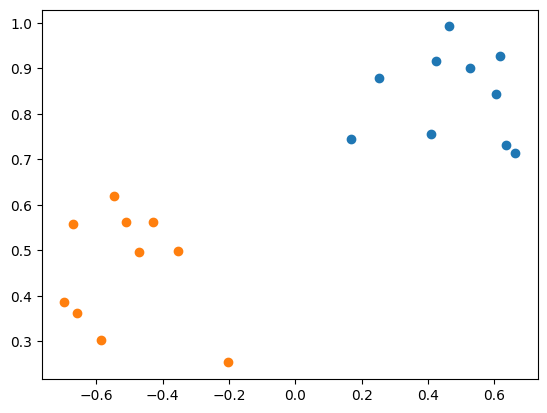

In [44]:
import matplotlib.pyplot as plt
latent_samples = latent_samples.detach().cpu()
plt.scatter(latent_samples[2::32,5],latent_samples[2::32,6])
plt.scatter(latent_samples[10::32,5],latent_samples[10::32,6])

In [ ]:
latent_samples = []
for _ in range(10):
    latent_samples.append(vae.reparameterize(latent_mean, latent_logvar))
latent_samples = torch.cat(latent_samples, dim=0) # sample* B, 3


In [ ]:
latent_samples[::32,:5]

torch.Size([320, 256])

100%|██████████| 119/119 [00:00<00:00, 142.70it/s]

result: [{'type': 'start'}, {'value': 8, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 20, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


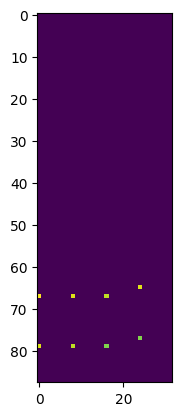

In [ ]:
import matplotlib.pyplot as plt
tokens, pr = inference(torch.randn(1, 256).to(device), output_dir/f'{epoch}_{i}_random.mid', length=120)
plt.imshow(pr.to_tensor(start_time=0,end_time=32,padding=True).transpose(0,1).flip(0)/127)


In [ ]:
tokens

[{'type': 'start'},
 {'value': 27, 'type': 'pitch'},
 {'value': 15, 'type': 'velocity'},
 {'value': 39, 'type': 'pitch'},
 {'value': 19, 'type': 'velocity'},
 {'value': 46, 'type': 'pitch'},
 {'value': 17, 'type': 'velocity'},
 {'value': 51, 'type': 'pitch'},
 {'value': 21, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 34, 'type': 'pitch'},
 {'value': 15, 'type': 'velocity'},
 {'value': 51, 'type': 'pitch'},
 {'value': 22, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 39, 'type': 'pitch'},
 {'value': 16, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 27, 'type': 'pitch'},
 {'value': 13, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 31, 'type': 'pitc

In [ ]:
mean = torch.zeros(2,2000)
var = torch.ones(2,2000)
mean[0,0] += 2
get_confidence(mean, var)

tensor(0.8808)

In [ ]:
get_confidence(latent_mean*500, latent_logvar.exp())

tensor(0.5097, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
tokenizer.idx_to_token_seq(batch['indices'][0].cpu().numpy())

[{'type': 'start'},
 {'value': 17, 'type': 'pitch'},
 {'value': 20, 'type': 'velocity'},
 {'value': 43, 'type': 'pitch'},
 {'value': 20, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 24, 'type': 'pitch'},
 {'value': 17, 'type': 'velocity'},
 {'value': 36, 'type': 'pitch'},
 {'value': 20, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 29, 'type': 'pitch'},
 {'value': 20, 'type': 'velocity'},
 {'value': 46, 'type': 'pitch'},
 {'value': 22, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 46, 'type': 'pitch'},
 {'value': 20, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'value': 46, 'type': 'pitch'},
 {'value': 21, 'type': 'velocity'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'type': 'next_frame'},
 {'